# Week 6 tutorial - Linear Model Selection and Regularization

02-Sep-2016

The materials used in this tutorial are based on the applied exercises provided in the book "An Introduction to Statistical Learning with Applications in R" (ISLR). We are trying to demonstrate how to implement the following methods of selecting the most appropriate model that explains the your data:
    * Subset selection
    * Shrinkage method
        * Ridge regression (L-2 regularization)
        * Lasso (L-1 regularization)

Even though you will learn how to use the above methods, it still is worth trying by yourself
    1. Sections 6.5 and 6.6
    1. The other practical exercises in section 6.8 (optional)
    
The libraries that you needed are
* <a href="https://cran.r-project.org/web/packages/leaps/index.html">leaps</a>
* <a href="https://cran.r-project.org/web/packages/glmnet/index.html">glmnet</a>
    
## 1. Subset Selection, Stepwise Selection and Lasso for selection features

Subset selection is an approach of identifying a subset of predictors (or attributes) that we believe have strong an association with the response variable. In this exercise, we will generate simulated data, and will use this data to perform best subset selection.

### 1.1 Generate simulated data
Here, we are going to use the <a href="https://stat.ethz.ch/R-manual/R-devel/library/stats/html/Normal.html">rnorm()</a> function to generate a predictor $X$ of length $n = 100$, as well as a noise vector of length $n = 100$. Note that we start with setting the seed for the random number generate, the purpose of which is to make our analysis reproducible. 

In [1]:
set.seed(1)

We first generate 100 random values that are normally distributed:

In [2]:
x <- rnorm(100)

In [3]:
x

[1] -0.626453811  0.183643324 -0.835628612  1.595280802  0.329507772
  [6] -0.820468384  0.487429052  0.738324705  0.575781352 -0.305388387
 [11]  1.511781168  0.389843236 -0.621240581 -2.214699887  1.124930918
 [16] -0.044933609 -0.016190263  0.943836211  0.821221195  0.593901321
 [21]  0.918977372  0.782136301  0.074564983 -1.989351696  0.619825748
 [26] -0.056128740 -0.155795507 -1.470752384 -0.478150055  0.417941560
 [31]  1.358679552 -0.102787727  0.387671612 -0.053805041 -1.377059557
 [36] -0.414994563 -0.394289954 -0.059313397  1.100025372  0.763175748
 [41] -0.164523596 -0.253361680  0.696963375  0.556663199 -0.688755695
 [46] -0.707495157  0.364581962  0.768532925 -0.112346212  0.881107726
 [51]  0.398105880 -0.612026393  0.341119691 -1.129363096  1.433023702
 [56]  1.980399899 -0.367221476 -1.044134626  0.569719627 -0.135054604
 [61]  2.401617761 -0.039240003  0.689739362  0.028002159 -0.743273209
 [66]  0.188792300 -1.804958629  1.465554862  0.153253338  2.172611670
 [71]  0.475509529 -0.709946431  0.610726353 -0.934097632 -1.253633400
 [76]  0.291446236 -0.443291873  0.001105352  0.074341324 -0.589520946
 [81] -0.568668733 -0.135178615  1.178086997 -1.523566800  0.593946188
 [86]  0.332950371  1.063099837 -0.304183924  0.370018810  0.267098791
 [91] -0.542520031  1.207867806  1.160402616  0.700213650  1.586833455
 [96]  0.558486426 -1.276592208 -0.573265414 -1.224612615 -0.473400636

Then, generate some random noises as irreducible errors.

In [4]:
eps <- rnorm(100)

In [5]:
eps

[1] -0.62036668  0.04211587 -0.91092165  0.15802877 -0.65458464  1.76728727
  [7]  0.71670748  0.91017423  0.38418536  1.68217608 -0.63573645 -0.46164473
 [13]  1.43228224 -0.65069635 -0.20738074 -0.39280793 -0.31999287 -0.27911330
 [19]  0.49418833 -0.17733048 -0.50595746  1.34303883 -0.21457941 -0.17955653
 [25] -0.10019074  0.71266631 -0.07356440 -0.03763417 -0.68166048 -0.32427027
 [31]  0.06016044 -0.58889449  0.53149619 -1.51839408  0.30655786 -1.53644982
 [37] -0.30097613 -0.52827990 -0.65209478 -0.05689678 -1.91435943  1.17658331
 [43] -1.66497244 -0.46353040 -1.11592011 -0.75081900  2.08716655  0.01739562
 [49] -1.28630053 -1.64060553  0.45018710 -0.01855983 -0.31806837 -0.92936215
 [55] -1.48746031 -1.07519230  1.00002880 -0.62126669 -1.38442685  1.86929062
 [61]  0.42510038 -0.23864710  1.05848305  0.88642265 -0.61924305  2.20610246
 [67] -0.25502703 -1.42449465 -0.14439960  0.20753834  2.30797840  0.10580237
 [73]  0.45699881 -0.07715294 -0.33400084 -0.03472603  0.78763961  2.07524501
 [79]  1.02739244  1.20790840 -1.23132342  0.98389557  0.21992480 -1.46725003
 [85]  0.52102274 -0.15875460  1.46458731 -0.76608200 -0.43021175 -0.92610950
 [91] -0.17710396  0.40201178 -0.73174817  0.83037317 -1.20808279 -1.04798441
 [97]  1.44115771 -1.01584747  0.41197471 -0.38107605

Now, we can generate a response vector $Y$ of length $n = 100$ according to the model 
    $Y = \beta_0+\beta_1 X +\beta_2 X^2 +\beta_3 X^3 + \epsilon $ 
where $\beta_0$, $\beta_1$, $\beta_2$ and $\beta_3$  are constants of your choice.
Here, we will set those coefficients as follows.

In [6]:
b0 <- 2
b1 <- 3
b2 <- -1
b3 <- 0.5

Given the coefficients, it is not hard to generate the simulated data using the polynomial function.

In [7]:
y <- b0 + b1 * x + b2 * x^2 + b3 * x^3 + eps

### 1.2  Perform best subset selection 
In this task, we will use the regsubsets() function (refer to the documentation of <a href="https://cran.r-project.org/web/packages/leaps/leaps.pdf">leaps</a> for the function specification) to perform best subset selection in order to choose the best model containing the predictors $X$, $X^2$, $\dots$, $X^{10}$. What is the best model obtained according to $C_p$, $BIC$, and adjusted $R^2$? Show some plots to provide evidence for your answer, and report the coefficients of the best model obtained. Note you will need to use the <a href="https://stat.ethz.ch/R-manual/R-devel/library/base/html/data.frame.html">data.frame()</a> function to create a single data set containing both $X$ and $Y$.

We start with loading the library,

In [8]:
library(leaps)

Warning message:
: package 'leaps' was built under R version 3.3.2

Then, put our data into a data frame,

In [9]:
data.full <- data.frame(y = y, x = x)
data.full

y                   x
1     -1.01509662418073  -0.626453810742332
2      2.56241764894581   0.183643324222082
3     -2.40783202264636  -0.835628612410047
4      6.42888201879526    1.59528080213779
5       2.2432515142398   0.329507771815361
6     0.356557065566636  -0.820468384118015
7      3.99931097506875   0.487429052428485
8      4.78126400046124   0.738324705129217
9      3.87544796376429   0.575781351653492
10     2.65850827592687  -0.305388387156356
11     5.34169930207434    1.51178116845085
12      2.5855309786596   0.389843236411431
13       1.062739887002  -0.621240580541804
14    -15.6311274602945    -2.2146998871775
15     4.61372536319847    1.12493091814311
16     1.47032685315843 -0.0449336090152309
17     1.63117209560217 -0.0161902630989461
18     4.08196582863119   0.943836210685299
19     4.56036519789077   0.821221195098089
20      3.3563947765743   0.593901321217509
21     3.79450235680251   0.918977371608218
22     5.31694146698786   0.782136300731067
23     2.00376289309987  0.0745649833651906
24    -12.0415815181048   -1.98935169586337
25     3.49416609918911    0.61982574789471
26     2.54104123807927 -0.0561287395290008
27     1.43288608289032  -0.155795506705329
28    -6.20370538588492   -1.47075238389927
29   -0.399397239215097   -0.47815005510862
30     2.79138126249836   0.417941560199702
...                 ...                 ...
71     5.56215623991613   0.475509528899663
72   -0.706975856447981  -0.709946430921815
73     4.03008758418036   0.610726353489055
74    -2.15950223541337  -0.934097631644252
75    -4.65160080406758    -1.2536334002391
76     2.76704962401158   0.291446235517463
77     1.21770117125132  -0.443291873218433
78     4.07855984242019 0.00110535163162413
79     3.24509520733034  0.0743413241516641
80    0.989371048729965  -0.589520946188072
81    -1.35266296875119  -0.568668732818502
82     2.55885138984086  -0.135178615123832
83     5.18382379688813     1.1780869965732
84    -8.12750035832013   -1.52356680042976
85     4.05485304590221   0.593946187628422
86     2.74769532403378   0.332950371213518
87      6.1244533187165    1.06309983727636
88    0.214765626436359  -0.304183923634301
89     2.56826111894113   0.370018809916288
90     1.81337276035952   0.267098790772231
91   -0.178831451946741   -0.54252003099165
92     5.44777668941461    1.20786780598317
93     4.18418636505784    1.16040261569495
94     4.61237204188638   0.700213649514998
95     5.03223254804881    1.58683345454085
96     2.40266571356201   0.558486425565304
97    -3.05852987398758   -1.27659220845804
98    -1.15847397701855  -0.573265414236886
99    -3.67980029751295   -1.22461261489836
100 -0.0784325964065791  -0.473400636439312

Now, let's have a look at our data.

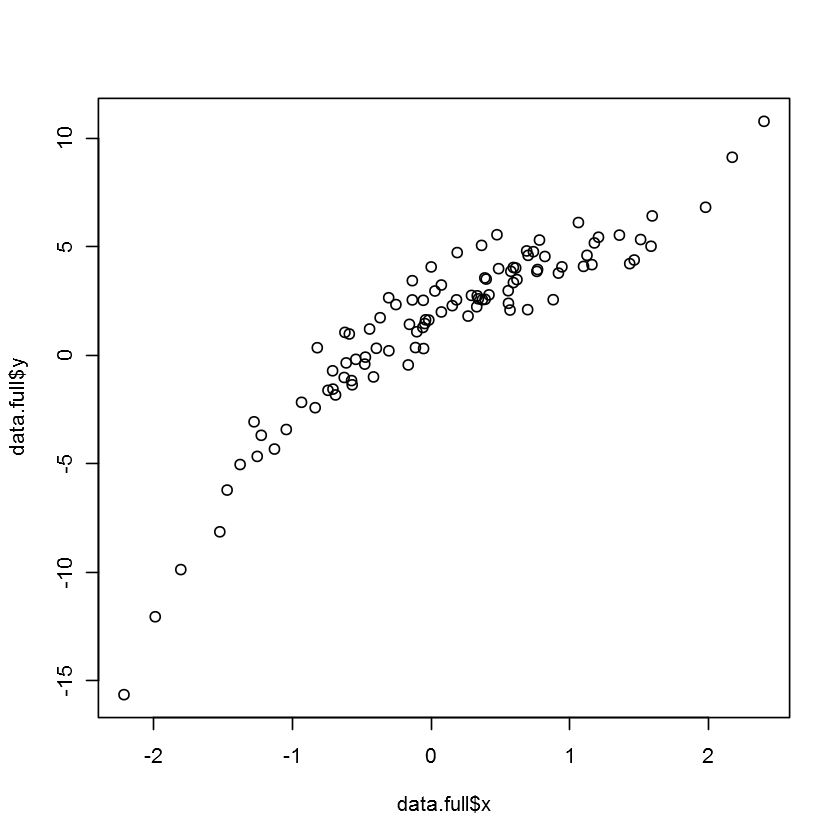

In [10]:
#plot(data.full)
plot(data.full$x, data.full$y)

It seems that the plot shows the relationship between $X$ and $Y$ is linear. However, it is indeed not, as our data were generated from a polynomial function with degree 3. Our goal here is to find the best model contains at most 10 variables, from $X$ to $X^{10}$. The first thing that you need to do is to call the <font color="blue"> regsubsets()</font> function. To see the documentation of this function, simply type

In [11]:
help(regsubsets)

The above documentation tells us that the first argument is the model formula for the full model, which is
$\hat{Y} = \beta_0 + \beta_1 X + \beta_2 X^2 + \dots + \beta_{10} x^{10}$. We should also specify the data and the maximum size of subset to examine, which is 10 here.

In [12]:
regfit.full <- regsubsets(y ~ x + I(x^2) + I(x^3) + I(x^4) + I(x^5) + I(x^6) + I(x^7) + I(x^8) + I(x^9) + I(x^10), data = data.full, nvmax = 10)

The summary() function will output the best set of variables for each model size from 1 to 10.

In [13]:
reg.summary <- summary(regfit.full)
reg.summary

Subset selection object
Call: regsubsets.formula(y ~ x + I(x^2) + I(x^3) + I(x^4) + I(x^5) + 
    I(x^6) + I(x^7) + I(x^8) + I(x^9) + I(x^10), data = data.full, 
    nvmax = 10)
10 Variables  (and intercept)
        Forced in Forced out
x           FALSE      FALSE
I(x^2)      FALSE      FALSE
I(x^3)      FALSE      FALSE
I(x^4)      FALSE      FALSE
I(x^5)      FALSE      FALSE
I(x^6)      FALSE      FALSE
I(x^7)      FALSE      FALSE
I(x^8)      FALSE      FALSE
I(x^9)      FALSE      FALSE
I(x^10)     FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: exhaustive
          x   I(x^2) I(x^3) I(x^4) I(x^5) I(x^6) I(x^7) I(x^8) I(x^9) I(x^10)
1  ( 1 )  "*" " "    " "    " "    " "    " "    " "    " "    " "    " "    
2  ( 1 )  "*" "*"    " "    " "    " "    " "    " "    " "    " "    " "    
3  ( 1 )  "*" "*"    " "    " "    "*"    " "    " "    " "    " "    " "    
4  ( 1 )  "*" "*"    " "    "*"    "*"    " "    " "    " "    " "    " "    
5  ( 1 )  "*" "*"  

An asterisk indicates that a variable in the corresponding column is included in the model. For example, the best one-variable model only contains $X$and  the best three-variable model contains $X$, $X^2$ and $X^5$. As discussed in section 6.5.1 in the text book, ISLR, the <font color="orange">nvmax</font> option can be used in order to return as many as variables as are desired, subject to $nvmax <= p$. Besides, what has been show above, the <font color="blue">summary()</font> function also returns:

In [14]:
names(reg.summary)

[1] "which"  "rsq"    "rss"    "adjr2"  "cp"     "bic"    "outmat" "obj"

In [15]:
reg.summary

Subset selection object
Call: regsubsets.formula(y ~ x + I(x^2) + I(x^3) + I(x^4) + I(x^5) + 
    I(x^6) + I(x^7) + I(x^8) + I(x^9) + I(x^10), data = data.full, 
    nvmax = 10)
10 Variables  (and intercept)
        Forced in Forced out
x           FALSE      FALSE
I(x^2)      FALSE      FALSE
I(x^3)      FALSE      FALSE
I(x^4)      FALSE      FALSE
I(x^5)      FALSE      FALSE
I(x^6)      FALSE      FALSE
I(x^7)      FALSE      FALSE
I(x^8)      FALSE      FALSE
I(x^9)      FALSE      FALSE
I(x^10)     FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: exhaustive
          x   I(x^2) I(x^3) I(x^4) I(x^5) I(x^6) I(x^7) I(x^8) I(x^9) I(x^10)
1  ( 1 )  "*" " "    " "    " "    " "    " "    " "    " "    " "    " "    
2  ( 1 )  "*" "*"    " "    " "    " "    " "    " "    " "    " "    " "    
3  ( 1 )  "*" "*"    " "    " "    "*"    " "    " "    " "    " "    " "    
4  ( 1 )  "*" "*"    " "    "*"    "*"    " "    " "    " "    " "    " "    
5  ( 1 )  "*" "*"  

We can examine these outputs to identify the best overall model. First, let's find the best overall model using Mallow's CP.

In [16]:
reg.summary$cp

[1] 191.908677  63.788757  -1.340110   0.354922   2.052791   3.853556
 [7]   5.264784   7.169409   9.065416  11.000000

In [17]:
which.min(reg.summary$cp)

[1] 3

[1] 3

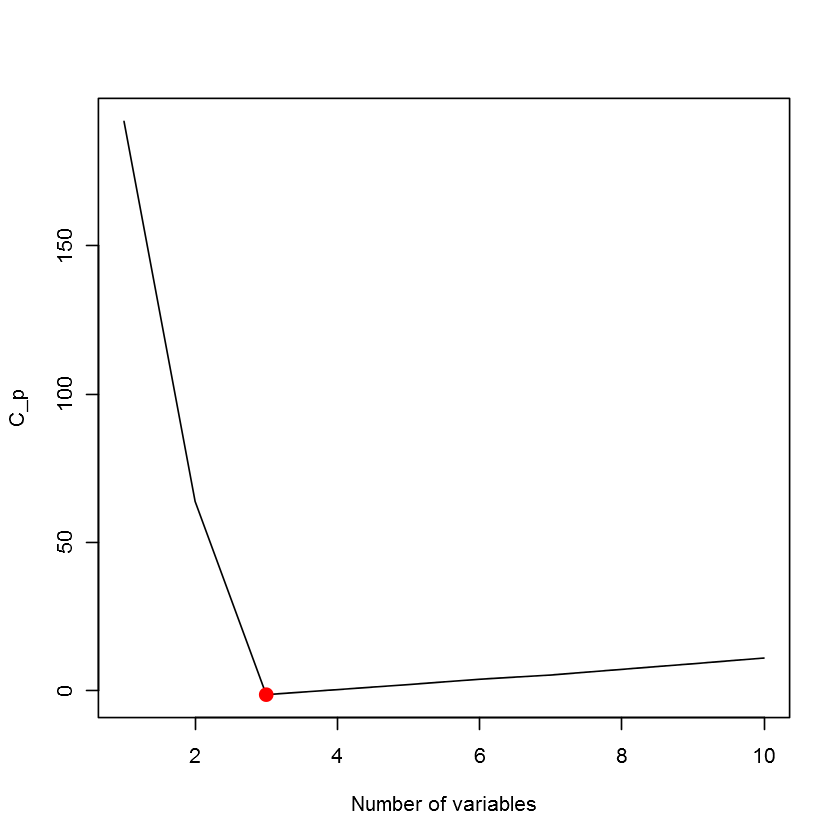

In [18]:
plot(reg.summary$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
mincp = which.min(reg.summary$cp)
points(mincp, reg.summary$cp[mincp], col = "red", cex = 2, pch = 20)
mincp

The plot suggests that the best overall model is a model with 3 variables, what are the three variables and their coefficients?

In [19]:
coef(regfit.full, mincp)

(Intercept)           x      I(x^2)      I(x^5) 
 2.07219472  3.44514720 -1.15676236  0.09022577

Similarly, we can use some other criteria, such as BIC and RSS. Let's try BIC first.

(Intercept)           x      I(x^2)      I(x^5) 
 2.07219472  3.44514720 -1.15676236  0.09022577

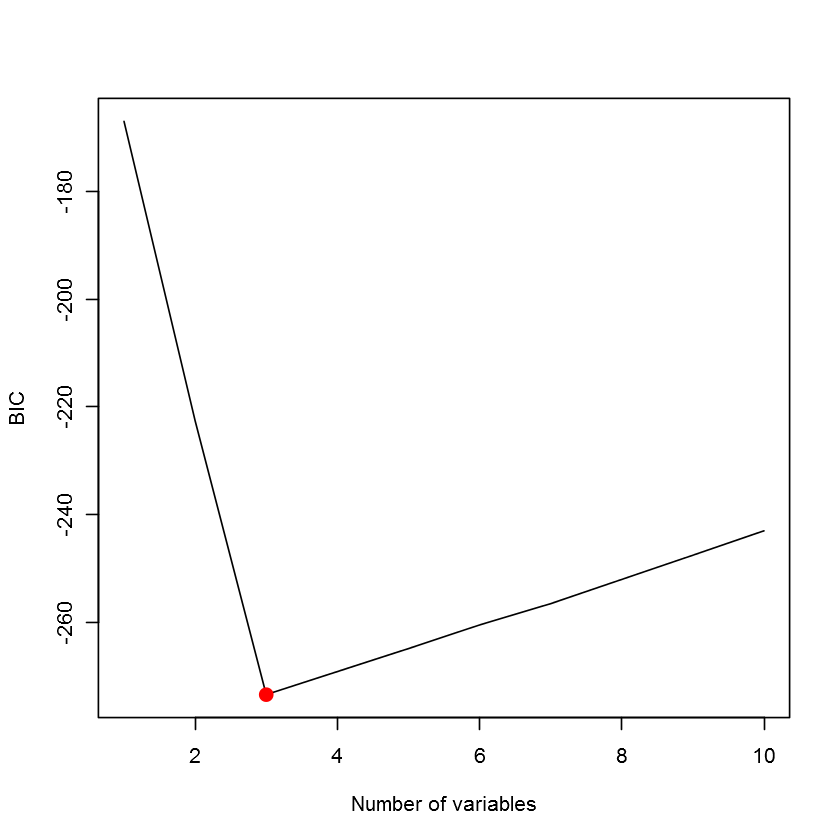

In [20]:
plot(reg.summary$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
minbic = which.min(reg.summary$bic)
points(minbic, reg.summary$bic[minbic], col = "red", cex = 2, pch = 20)
coef(regfit.full, minbic)

The BIC gives us the same model as did CP. How about using adjusted $R^2$,

(Intercept)           x      I(x^2)      I(x^5) 
 2.07219472  3.44514720 -1.15676236  0.09022577

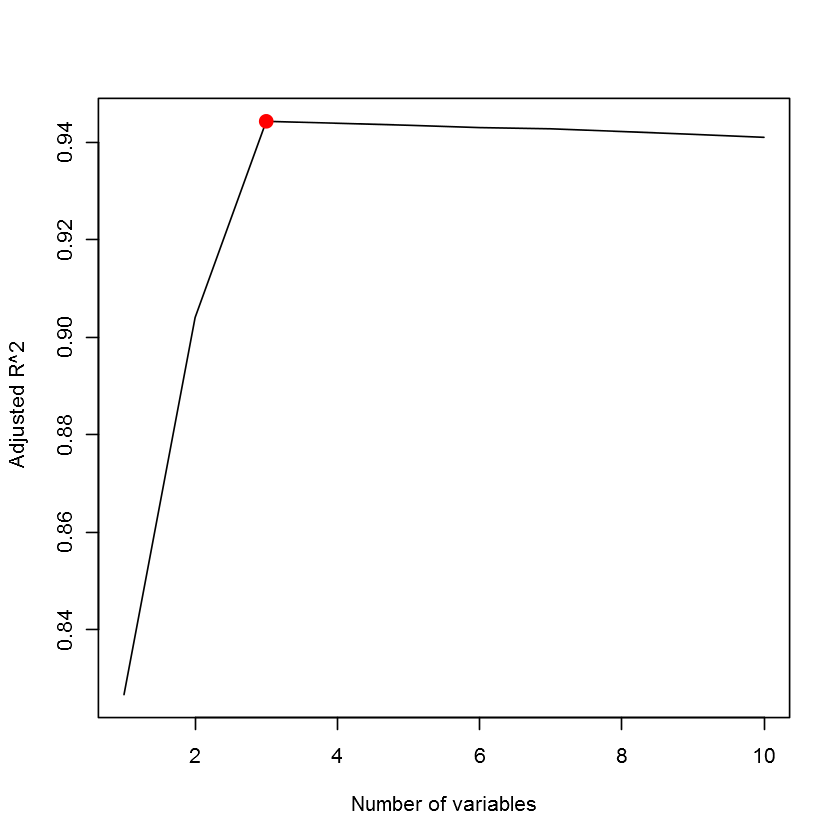

In [21]:
plot(reg.summary$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
max_adjr2 = which.max(reg.summary$adjr2)
points(max_adjr2, reg.summary$adjr2[max_adjr2 ], col = "red", cex = 2, pch = 20)
coef(regfit.full, max_adjr2)

It is interesting that the three criteria gave us the the same overall best model. We can further have a look at the RSS plot.

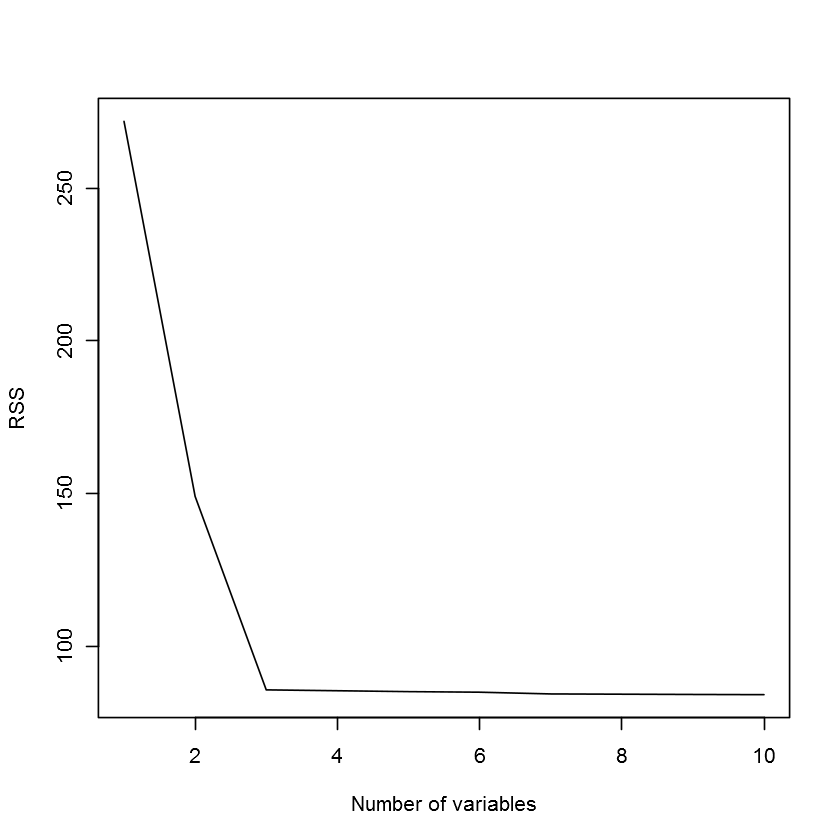

In [22]:
plot(reg.summary$rss, xlab = "Number of variables", ylab = "RSS", type = "l")

What we observed is that RSS decrease monotonicity as the number variable increases.

## 1.3 Perform stepwise selection

One drawback of best subset selection is its time complexity. In general, the number of models that you need to fit is $2^p$, which is infeasible if $p$ is large, for example, if $p =10$. It also easily results in a model that fits the training data perfectly but performing badly on unseen data. In this section, we are going to explore alternative methods, known as stepwise selection, which explore a far more restricted set of models. There are three stepwise selection methods:
* <b>Forward stepwise selection</b>: Starts with one-variable models, gradually add one variable, end with a model including all the specified variables.
* <b>Backward stepwise selection</b>: Starts with a full model, gradually exclude one variable, end with one-variable models.
* <b>Hybrid selection</b>: the combination of Forward stepwise selection and Backward stepwise selection.

We begin with forward stepwise selection. It is very easy to implement the forward stepwise selection method with <font color="blue">regsubsets()</font>: 

In [23]:
regfit.fwd <- regsubsets(y ~ x + I(x^2) + I(x^3) + I(x^4) + I(x^5) + I(x^6) + I(x^7) + I(x^8) + I(x^9) + I(x^10), 
                         data = data.full, nvmax = 10, method = "forward")

In [24]:
reg.summary.fwd <- summary(regfit.fwd)
reg.summary.fwd 
reg.summary

Subset selection object
Call: regsubsets.formula(y ~ x + I(x^2) + I(x^3) + I(x^4) + I(x^5) + 
    I(x^6) + I(x^7) + I(x^8) + I(x^9) + I(x^10), data = data.full, 
    nvmax = 10, method = "forward")
10 Variables  (and intercept)
        Forced in Forced out
x           FALSE      FALSE
I(x^2)      FALSE      FALSE
I(x^3)      FALSE      FALSE
I(x^4)      FALSE      FALSE
I(x^5)      FALSE      FALSE
I(x^6)      FALSE      FALSE
I(x^7)      FALSE      FALSE
I(x^8)      FALSE      FALSE
I(x^9)      FALSE      FALSE
I(x^10)     FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: forward
          x   I(x^2) I(x^3) I(x^4) I(x^5) I(x^6) I(x^7) I(x^8) I(x^9) I(x^10)
1  ( 1 )  "*" " "    " "    " "    " "    " "    " "    " "    " "    " "    
2  ( 1 )  "*" "*"    " "    " "    " "    " "    " "    " "    " "    " "    
3  ( 1 )  "*" "*"    " "    " "    "*"    " "    " "    " "    " "    " "    
4  ( 1 )  "*" "*"    " "    "*"    "*"    " "    " "    " "    " "    " "    
5 

Subset selection object
Call: regsubsets.formula(y ~ x + I(x^2) + I(x^3) + I(x^4) + I(x^5) + 
    I(x^6) + I(x^7) + I(x^8) + I(x^9) + I(x^10), data = data.full, 
    nvmax = 10)
10 Variables  (and intercept)
        Forced in Forced out
x           FALSE      FALSE
I(x^2)      FALSE      FALSE
I(x^3)      FALSE      FALSE
I(x^4)      FALSE      FALSE
I(x^5)      FALSE      FALSE
I(x^6)      FALSE      FALSE
I(x^7)      FALSE      FALSE
I(x^8)      FALSE      FALSE
I(x^9)      FALSE      FALSE
I(x^10)     FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: exhaustive
          x   I(x^2) I(x^3) I(x^4) I(x^5) I(x^6) I(x^7) I(x^8) I(x^9) I(x^10)
1  ( 1 )  "*" " "    " "    " "    " "    " "    " "    " "    " "    " "    
2  ( 1 )  "*" "*"    " "    " "    " "    " "    " "    " "    " "    " "    
3  ( 1 )  "*" "*"    " "    " "    "*"    " "    " "    " "    " "    " "    
4  ( 1 )  "*" "*"    " "    "*"    "*"    " "    " "    " "    " "    " "    
5  ( 1 )  "*" "*"  

Have you observed the differences between the above output and that generated by the best subset selection? For example, is the five-variable model generated by the forward stepwise selection the same as the one generated by the best subset selection? 

The answer is No. the five-variable model generated by the forward stepwise selection contains $X$, $X^2$, $X^4$, $X^5$ and $X^9$. However, the one generated by the best subset selection contains $X$, $X^2$, $X^5$, $X^8$ and $X^9$. You can also find that the 6,7,8-variable models are also different.

Now, what is the overall best model? Similarly, we can generate a set of plots to identify the best overall model as follows.

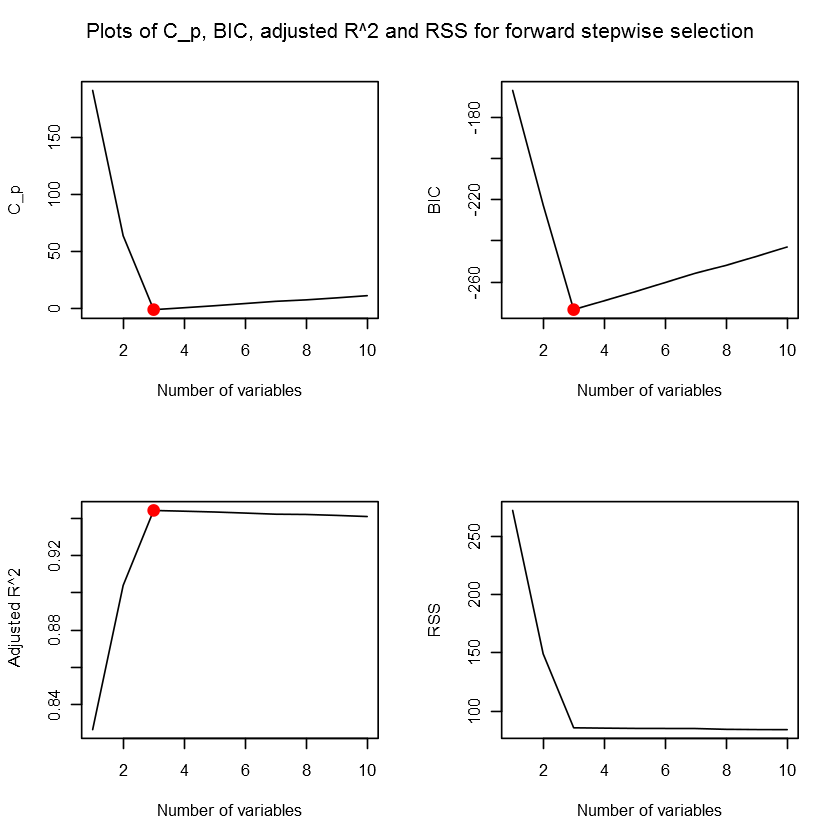

In [25]:
par(mfrow = c(2, 2))
plot(reg.summary.fwd$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
points(which.min(reg.summary.fwd$cp), reg.summary.fwd$cp[which.min(reg.summary.fwd$cp)], col = "red", cex = 2, pch = 20)
plot(reg.summary.fwd$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
points(which.min(reg.summary.fwd$bic), reg.summary.fwd$bic[which.min(reg.summary.fwd$bic)], col = "red", cex = 2, pch = 20)
plot(reg.summary.fwd$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
points(which.max(reg.summary.fwd$adjr2), reg.summary.fwd$adjr2[which.max(reg.summary.fwd$adjr2)], col = "red", cex = 2, pch = 20)
plot(reg.summary.fwd$rss, xlab = "Number of variables", ylab = "RSS", type = "l")
mtext("Plots of C_p, BIC, adjusted R^2 and RSS for forward stepwise selection", side = 3, line = -2, outer = TRUE)

The above plots show that the best overall model is still the 3-variable model. How about the coefficients?

In [26]:
coef(regfit.fwd, 3)

(Intercept)           x      I(x^2)      I(x^5) 
 2.07219472  3.44514720 -1.15676236  0.09022577

You will find the estimated coefficients are the same.

Now, let's have a look at the backward selection method. To implement it, we just simply, change the value of <font color="orange">method</font> to <b>backward</b>.

In [27]:
regfit.bwd <- regsubsets(y ~ x + I(x^2) + I(x^3) + I(x^4) + I(x^5) + I(x^6) + I(x^7) + I(x^8) + I(x^9) + I(x^10), data = data.full, nvmax = 10, method = "backward")
reg.summary.bwd <- summary(regfit.bwd)
reg.summary.bwd

Subset selection object
Call: regsubsets.formula(y ~ x + I(x^2) + I(x^3) + I(x^4) + I(x^5) + 
    I(x^6) + I(x^7) + I(x^8) + I(x^9) + I(x^10), data = data.full, 
    nvmax = 10, method = "backward")
10 Variables  (and intercept)
        Forced in Forced out
x           FALSE      FALSE
I(x^2)      FALSE      FALSE
I(x^3)      FALSE      FALSE
I(x^4)      FALSE      FALSE
I(x^5)      FALSE      FALSE
I(x^6)      FALSE      FALSE
I(x^7)      FALSE      FALSE
I(x^8)      FALSE      FALSE
I(x^9)      FALSE      FALSE
I(x^10)     FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: backward
          x   I(x^2) I(x^3) I(x^4) I(x^5) I(x^6) I(x^7) I(x^8) I(x^9) I(x^10)
1  ( 1 )  "*" " "    " "    " "    " "    " "    " "    " "    " "    " "    
2  ( 1 )  "*" "*"    " "    " "    " "    " "    " "    " "    " "    " "    
3  ( 1 )  "*" "*"    " "    " "    "*"    " "    " "    " "    " "    " "    
4  ( 1 )  "*" "*"    " "    "*"    "*"    " "    " "    " "    " "    " "    


In [28]:
#help(regsubsets)

Can you identify the differences between the models selected by the backward selection method and those selected by the forward selection method?

Similarly, we can find the best overall model given by the backward selection method.

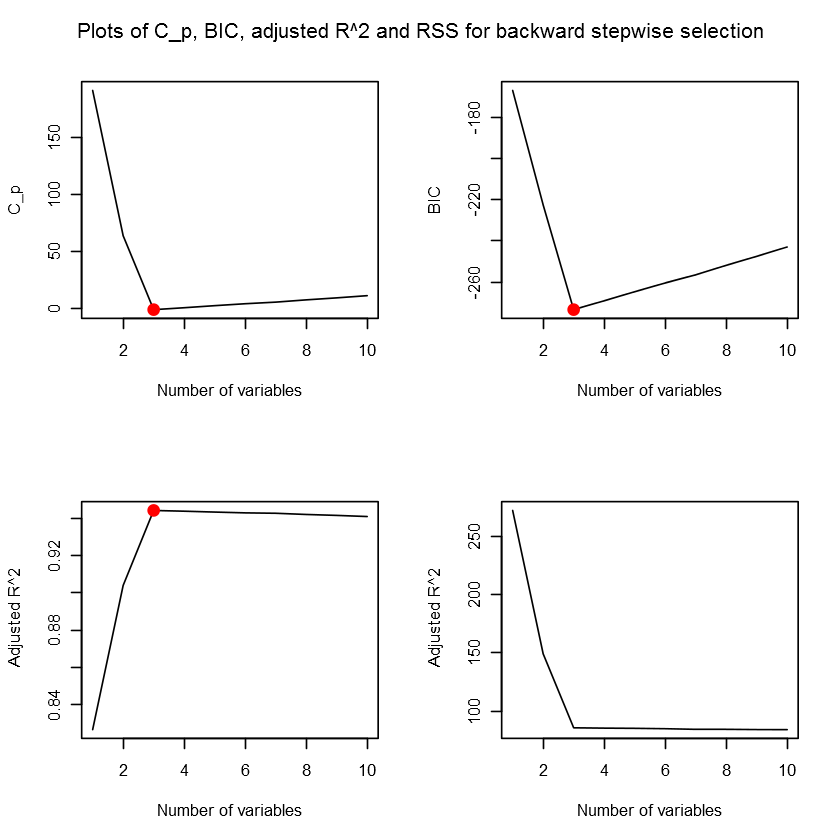

In [29]:
par(mfrow = c(2, 2))
plot(reg.summary.bwd$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
points(which.min(reg.summary.bwd$cp), reg.summary.bwd$cp[which.min(reg.summary.bwd$cp)], col = "red", cex = 2, pch = 20)
plot(reg.summary.bwd$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
points(which.min(reg.summary.bwd$bic), reg.summary.bwd$bic[which.min(reg.summary.bwd$bic)], col = "red", cex = 2, pch = 20)
plot(reg.summary.bwd$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
points(which.max(reg.summary.bwd$adjr2), reg.summary.bwd$adjr2[which.max(reg.summary.bwd$adjr2)], col = "red", cex = 2, pch = 20)
plot(reg.summary.bwd$rss, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
mtext("Plots of C_p, BIC, adjusted R^2 and RSS for backward stepwise selection", side = 3, line = -2, outer = TRUE)

The best overall model is still the three-variable model with exactly the same variables.

## 1.4 Perform Lasso
What we have done so far is about selecting the best subset of variables used in the model, which is often known as feature selection. As discussed in the lecture, the Lasso is one approach that we often used in machine learning to perform feature selection automatically. Depending on the shrinkage parameter, Lasso regularizes the coefficient in a way such that the estimated coefficients can be shrunk toward zero. The R library that we are going to use is the <font color="orange">glmnet</font>. It's document table can be found <a href="https://cran.r-project.org/web/packages/glmnet/glmnet.pdf">here</a>. Remember that it is always a good idea to refer to the library documentation to check the usage of a given function. The main function that we are going to use is <font color="blue">glmnet()</font>.

In [30]:
library(glmnet)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



In [31]:
help(glmnet)

Now we are ready to fit a lasso model to the simulated data, again using $X$,$X_2$, $\dots$, $X_{10}$ as predictors. Use cross-validation to select the optimal value of $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the resulting coefficient estimates, and discuss the results obtained.


In [32]:
xmat <- model.matrix(y ~ x + I(x^2) + I(x^3) + I(x^4) + I(x^5) + I(x^6) + I(x^7) + I(x^8) + I(x^9) + I(x^10), data = data.full)[, -1]

As discussed in section 6.6, the <a href="https://stat.ethz.ch/R-manual/R-devel/library/stats/html/model.matrix.html">model.matrix</a> function produces a data matrix corresponding to the 10 variables and also transforms any qualitative variables into dummy variables. In this case, we don't have qualitative variables. You should note that <font color="blue">glmnet()</font> can only take numerical, quantitative inputs.

Now, we fit a lasso model with cross-validation using the <font color="blue">cv.glmnet()</font> function

In [33]:
head(xmat)

x     I(x^2)       I(x^3)      I(x^4)        I(x^5)       I(x^6)
1 -0.6264538 0.39244438 -0.245848275 0.154012589 -0.0964817733 6.044137e-02
2  0.1836433 0.03372487  0.006193347 0.001137367  0.0002088698 3.835755e-05
3 -0.8356286 0.69827518 -0.583498718 0.487588224 -0.4074426711 3.404708e-01
4  1.5952808 2.54492084  4.059863355 6.476622070 10.3320308510 1.648249e+01
5  0.3295078 0.10857537  0.035776429 0.011788611  0.0038844391 1.279953e-03
6 -0.8204684 0.67316837 -0.552313364 0.453155653 -0.3717998868 3.050501e-01
         I(x^7)       I(x^8)        I(x^9)      I(x^10)
1 -3.786373e-02 2.371988e-02 -1.485941e-02 9.308733e-03
2  7.044108e-06 1.293603e-06  2.375616e-07 4.362661e-08
3 -2.845071e-01 2.377423e-01 -1.986642e-01 1.660095e-01
4  2.629420e+01 4.194663e+01  6.691666e+01 1.067509e+02
5  4.217544e-04 1.389714e-04  4.579214e-05 1.508887e-05
6 -2.502839e-01 2.053500e-01 -1.684832e-01 1.382352e-01

In [34]:
cv.lasso <- cv.glmnet(xmat, y, alpha = 1)

If <font color="orange">alpha</font> is set to 0, a Ridge regression model is going to be fit. The default number of folds used is 10. You can also set the number of folds by specifying the value of <font color="orange">nfolds</font>. To see more detailed usage of cv.glmnet, simply type
```R
help(cv.glmnet)
```

We can plot the MSE as a function of the logarithm of $\lambda$ with error bars.

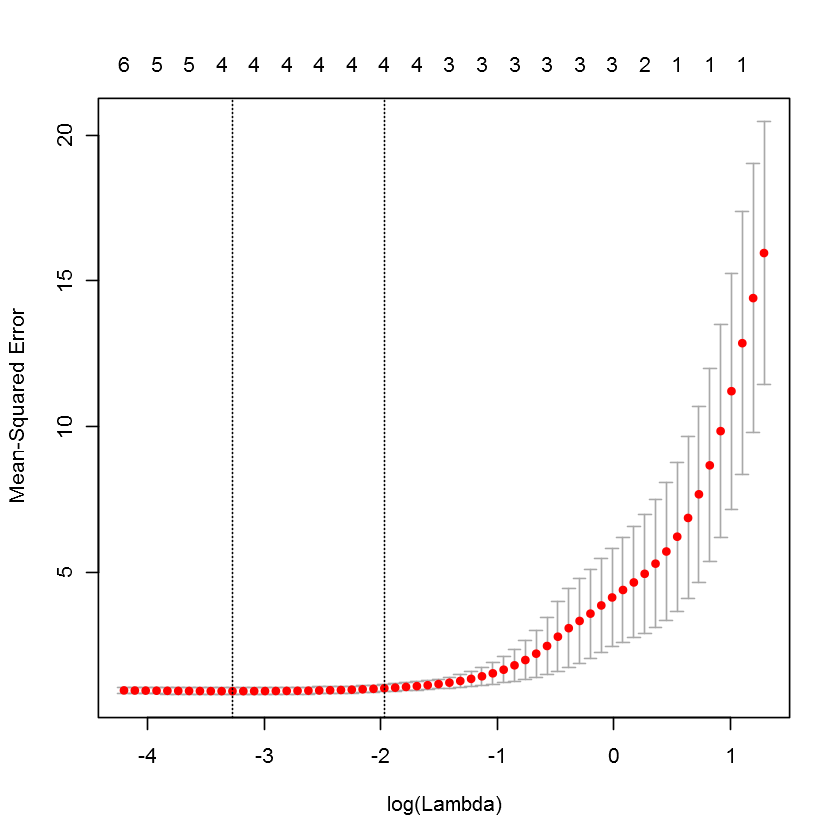

In [35]:
plot(cv.lasso)

What is the cross-validated lambda value?

In [36]:
bestlam <- cv.lasso$lambda.min
bestlam

[1] 0.03795616

Now we refit our lasso model using the value $\lambda= 0.0379562$ chosen by cross-validation.

In [55]:
fit.lasso <- glmnet(xmat, y, alpha = 1)
predict(fit.lasso, s = bestlam, type = "coefficients")[1:11, ]

(Intercept)           x      I(x^2)      I(x^3)      I(x^4)      I(x^5) 
 2.04091434  3.28373245 -1.10646862  0.14042235  0.00000000  0.06399454 
     I(x^6)      I(x^7)      I(x^8)      I(x^9)     I(x^10) 
 0.00000000  0.00000000  0.00000000  0.00000000  0.00000000

## 2. Lasso v.s. Ridge Regression

In machine learning, we alos call Lasso as $L_1$ regularizition and Ridge as $L_2$ regularization. The difference between the two regularization methods lies in how they penalise the estimated parameters of your model. The Ridge regularization will shrink all the estimated parameters twowards zero, but never equal to zero. In contrast, the Lasso regularization will force some of the estimated parameters to be zero. Besides the two regularization methods, there are other regularization methods, such as
* <a href="http://statweb.stanford.edu/~tibs/ftp/sparse-grlasso.pdf">group lasso</a>, which regularize the estimated parameters at a group level. Note you don't need to understand it, we just would like to let you be aware of the other regularization methods that are also used in data analysis. 

In this exercise, you are going to study how the Lasso and Ridge regularization 
affect the perforamnce of linear regression. We will develop a linear model to predict the number of applications received using the other variables in the <font color="orange">College</font> data set. We begin with splitting the data set into a training set and a testing set.



In [39]:
library(ISLR)
data(College)
set.seed(1)
dim(College)
train = sample(1:dim(College)[1], dim(College)[1] / 2)
test <- -train
College.train <- College[train, ]
College.test <- College[test, ]

[1] 777  18

Remeber that if you would like to check the specification of a R function, you can alwasy call the <font color="blue">help()</font> function. Here, we randonly select a half of the data records for training the linear model, and the other half to be in the testing data set.

### 2.1 Fit a least square model.
For the comparsion purpose, we first fit a linear model using least squares on the training set, and report the test error obtained.

In [40]:
fit.lm <- lm(Apps ~ ., data = College.train)

In [41]:
pred.lm <- predict(fit.lm, College.test)

In [42]:
mean((pred.lm - College.test$Apps)^2)

[1] 1108531

The means quare error is quite large. 

### 2.2 Reguarlize the coefficients with the $L_2$ regularization
Now, we are going to fit a ridge regression model on the training set, with the shrinkage parameter (or tunning) $\lambda$ chosen by cross-validation. Remember that the training data taken by the <font color="blue">glmnet</font> function (Type <font color="blue">help(glmnet)</font> to see its specification) should be a matrix. So we have to store all the training and testing datasets in two matrices. 

In [43]:
train.mat <- model.matrix(Apps ~ ., data = College.train)[,-1]
test.mat <- model.matrix(Apps ~ ., data = College.test)[,-1]

Now, we generate a list of lambda values that will be used in cross-validation.

In [44]:
grid <- 10^seq(4, -2, length = 100)

In [54]:
grid

[1] 1.000000e+04 8.697490e+03 7.564633e+03 6.579332e+03 5.722368e+03
  [6] 4.977024e+03 4.328761e+03 3.764936e+03 3.274549e+03 2.848036e+03
 [11] 2.477076e+03 2.154435e+03 1.873817e+03 1.629751e+03 1.417474e+03
 [16] 1.232847e+03 1.072267e+03 9.326033e+02 8.111308e+02 7.054802e+02
 [21] 6.135907e+02 5.336699e+02 4.641589e+02 4.037017e+02 3.511192e+02
 [26] 3.053856e+02 2.656088e+02 2.310130e+02 2.009233e+02 1.747528e+02
 [31] 1.519911e+02 1.321941e+02 1.149757e+02 1.000000e+02 8.697490e+01
 [36] 7.564633e+01 6.579332e+01 5.722368e+01 4.977024e+01 4.328761e+01
 [41] 3.764936e+01 3.274549e+01 2.848036e+01 2.477076e+01 2.154435e+01
 [46] 1.873817e+01 1.629751e+01 1.417474e+01 1.232847e+01 1.072267e+01
 [51] 9.326033e+00 8.111308e+00 7.054802e+00 6.135907e+00 5.336699e+00
 [56] 4.641589e+00 4.037017e+00 3.511192e+00 3.053856e+00 2.656088e+00
 [61] 2.310130e+00 2.009233e+00 1.747528e+00 1.519911e+00 1.321941e+00
 [66] 1.149757e+00 1.000000e+00 8.697490e-01 7.564633e-01 6.579332e-01
 [71] 5.722368e-01 4.977024e-01 4.328761e-01 3.764936e-01 3.274549e-01
 [76] 2.848036e-01 2.477076e-01 2.154435e-01 1.873817e-01 1.629751e-01
 [81] 1.417474e-01 1.232847e-01 1.072267e-01 9.326033e-02 8.111308e-02
 [86] 7.054802e-02 6.135907e-02 5.336699e-02 4.641589e-02 4.037017e-02
 [91] 3.511192e-02 3.053856e-02 2.656088e-02 2.310130e-02 2.009233e-02
 [96] 1.747528e-02 1.519911e-02 1.321941e-02 1.149757e-02 1.000000e-02

With the generated list of possible lambda values, we can now fit the lasso model with the cv.glmnet function. Type 
```r
help(cv.glmnet)
```
to see the usage information of this function.

In [45]:
set.seed(1)# the purpose of fixing the seed of the random number generator is to make the result repeatable.
fit.ridge <- glmnet(train.mat, College.train$Apps, alpha = 0, lambda = grid, thresh = 1e-12)
cv.ridge <- cv.glmnet(train.mat, College.train$Apps, alpha = 0, lambda = grid, thresh = 1e-12)
bestlam.ridge <- cv.ridge$lambda.min
bestlam.ridge

[1] 0.01

In [46]:
pred.ridge <- predict(fit.ridge, s = bestlam.ridge, newx = test.mat)
mean((pred.ridge - College.test$Apps)^2)

[1] 1108514

### 2.3 Reguarlize the coefficients with the $L_1$ regularization
In this question, we will fit a lasso model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with the number of non-zero coefficient estimates.


In [47]:
set.seed(1)# the purpose of fixing the seed of the random number generator is to make the result repeatable.
fit.lasso <- glmnet(train.mat, College.train$Apps, alpha = 1, lambda = grid, thresh = 1e-12)
cv.lasso <- cv.glmnet(train.mat, College.train$Apps, alpha = 1, lambda = grid, thresh = 1e-12)
bestlam.lasso <- cv.lasso$lambda.min
bestlam.lasso

[1] 24.77076

In [48]:
pred.lasso <- predict(fit.lasso, s = bestlam.lasso, newx = test.mat)
mean((pred.lasso - College.test$Apps)^2)

[1] 1033353

In [49]:
predict(fit.lasso, s = bestlam.lasso, type = "coefficients")[1:17, ]

(Intercept)    PrivateYes        Accept        Enroll     Top10perc 
-3.643674e+02 -5.275298e+02  1.558307e+00 -4.260811e-01  5.027386e+01 
    Top25perc   F.Undergrad   P.Undergrad      Outstate    Room.Board 
-9.779700e+00 -1.442764e-02  0.000000e+00 -5.736821e-02  1.953147e-01 
        Books      Personal           PhD      Terminal     S.F.Ratio 
 1.804682e-02  3.182162e-03 -4.703700e+00 -2.979281e+00  0.000000e+00 
  perc.alumni        Expend 
-2.207319e+00  3.260339e-02

Now, we compare the three models:

In [50]:
mean((pred.lm - College.test$Apps)^2)
mean((pred.ridge - College.test$Apps)^2)
mean((pred.lasso - College.test$Apps)^2)

[1] 1108531

[1] 1108514

[1] 1033353

The lowest MSE is drived by the lasso model.


Optional readings:
https://rstudio-pubs-static.s3.amazonaws.com/2897_9220b21cfc0c43a396ff9abf122bb351.html